In [1]:
# 2025/12/4
# zhangzhong
# https://milvus.io/docs/full_text_search_with_milvus.md

In [2]:
# Full-text search is a traditional method for retrieving documents by matching specific keywords or phrases in the text

# While semantic search is better at understanding meaning and context, 
# full-text search excels at precise keyword matching, making it a useful complement to semantic search.

# A common approach to constructing a Retrieval-Augmented Generation (RAG) pipeline involves retrieving documents through both semantic search and full-text search, 
# followed by a reranking process to refine the results.

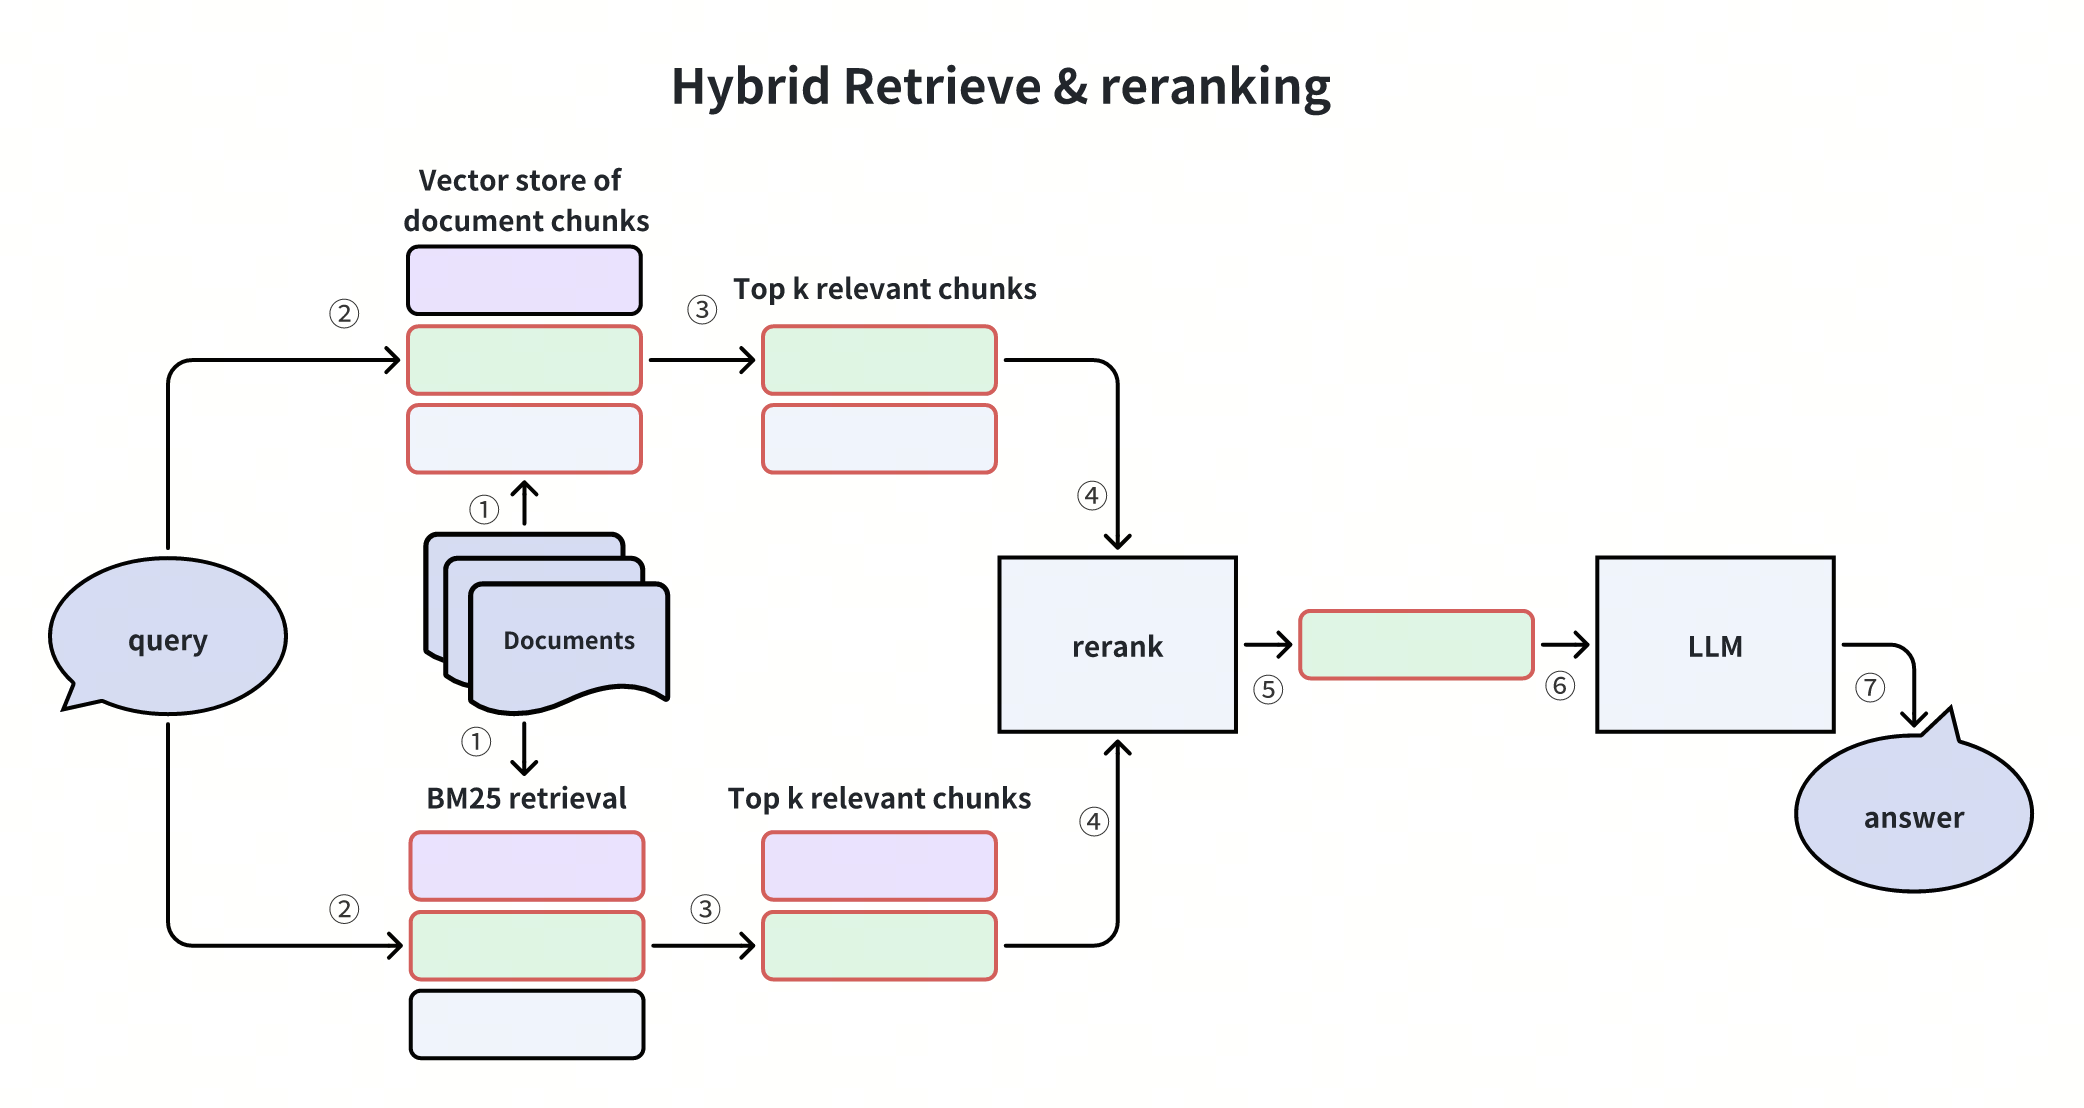

In [3]:
from typing import List
from zhipuai import ZhipuAI

from pymilvus import (
    MilvusClient,
    DataType,
    Function,
    FunctionType,
    AnnSearchRequest,
    RRFRanker,
)

In [4]:
import os
api_key = os.environ["BIGMODEL_API_KEY"]

In [5]:
from zhipuai import ZhipuAI

zhipu_client = ZhipuAI(api_key=api_key)
response = zhipu_client.embeddings.create(
    model="embedding-3", #填写需要调用的模型编码
    input=[
        "美食非常美味，服务员也很友好。",
        "这部电影既刺激又令人兴奋。",
        "阅读书籍是扩展知识的好方法。"
    ],
)
print(response)


def emb_text(text: str) -> list[float]:
    return (
        zhipu_client.embeddings.create(input=text, model="embedding-3")
        .data[0]
        .embedding
    )

def get_embeddings(strs: list[str]) -> list[list[float]]:
    return [
        emb_text(text) for text in strs
    ]

EmbeddingsResponded(object='list', data=[Embedding(object='embedding', index=0, embedding=[-0.019193882, -0.0024017915, 0.010312749, 0.0046962122, -0.029266322, -0.024214763, 0.013007254, 0.018161073, -0.0006557313, -0.014919485, -0.010532604, -0.0007758848, 0.0005876656, 0.030432068, 0.010000861, 0.007950583, 0.031168327, -0.0036889678, -0.05341973, -0.003231362, 0.034358785, -0.022885406, -0.020165335, 0.021003854, -0.022967212, 0.0033182816, -0.010808702, 0.043971065, 0.008717519, -0.012853867, 0.021249274, 0.12966351, 0.0059974487, -0.019510882, 0.046793394, 0.021781016, 0.023110373, 0.0037119759, 0.014510452, 0.028325547, 0.0071529676, 0.032579493, 0.012035801, -0.00029367302, 0.009187908, 0.0031367731, 0.003931831, -0.011463154, -0.00049659185, -0.0015057534, 0.0071478547, 0.008513003, 0.017547524, 0.01659652, -0.018478073, -0.0023072027, 0.006176401, 0.028898193, 0.006887096, -0.003080531, -0.02417386, 0.010092894, -0.018130396, 0.020216465, -0.0031930152, -0.0057008998, -0.0426

In [6]:
# We’ll use the MilvusClient to establish a connection to the Milvus server.
uri = "http://localhost:19530"
collection_name = "full_text_demo"
client = MilvusClient(uri=uri)


In [7]:
## Collection Setup for Full-Text Search
# 1. Text Analysis Configuration
# For full-text search, we define how text should be processed.
# yzers are essential in full-text search by breaking sentences into tokens and performing lexical analysis like stemming and stop word removal.
# https://milvus.io/docs/analyzer-overview.md
# TODO: 中文怎么做呢？

# Define tokenizer parameters for text analysis
analyzer_params = {"tokenizer": "standard", "filter": ["lowercase"]}

In [8]:
## Collection Schema and BM25 Function
# Now we define the schema with fields for primary key, text content, sparse vectors (for full-text search), dense vectors (for semantic search), and metadata.
# We also configure the BM25 function for full-text search.
# The BM25 function automatically converts text content into sparse vectors, allowing Milvus to handle the complexity of full-text search without requiring manual sparse embedding generation.

# Create schema
schema = MilvusClient.create_schema()
schema.add_field(
    field_name="id",
    datatype=DataType.VARCHAR,
    is_primary=True,
    auto_id=True,
    max_length=100,
)
schema.add_field(
    field_name="content",
    datatype=DataType.VARCHAR,
    max_length=65535,
    analyzer_params=analyzer_params,
    enable_match=True,  # Enable text matching
    enable_analyzer=True,  # Enable text analysis
)
schema.add_field(field_name="sparse_vector", datatype=DataType.SPARSE_FLOAT_VECTOR)
schema.add_field(
    field_name="dense_vector",
    datatype=DataType.FLOAT_VECTOR,
    dim=2048,  # Dimension for text-embedding-3-small
)
schema.add_field(field_name="metadata", datatype=DataType.JSON)

# Define BM25 function to generate sparse vectors from text
bm25_function = Function(
    name="bm25",
    function_type=FunctionType.BM25,
    input_field_names=["content"],
    output_field_names="sparse_vector",
)

# Add the function to schema
schema.add_function(bm25_function)

{'auto_id': False, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 100}, 'is_primary': True, 'auto_id': True}, {'name': 'content', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 65535, 'enable_match': True, 'enable_analyzer': True, 'analyzer_params': '{"tokenizer":"standard","filter":["lowercase"]}'}}, {'name': 'sparse_vector', 'description': '', 'type': <DataType.SPARSE_FLOAT_VECTOR: 104>, 'is_function_output': True}, {'name': 'dense_vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 2048}}, {'name': 'metadata', 'description': '', 'type': <DataType.JSON: 23>}], 'enable_dynamic_field': False, 'functions': [{'name': 'bm25', 'description': '', 'type': <FunctionType.BM25: 1>, 'input_field_names': ['content'], 'output_field_names': ['sparse_vector'], 'params': {}}]}

In [9]:
## Indexing and Collection Creation
# To optimize search performance, we create indexes for both sparse and dense vector fields, then create the collection in Milvus.
# https://milvus.io/docs/index-explained.md

# Define indexes
index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="sparse_vector",
    index_type="SPARSE_INVERTED_INDEX",
    metric_type="BM25",
)
index_params.add_index(field_name="dense_vector", index_type="FLAT", metric_type="IP")

# Drop collection if exist
if client.has_collection(collection_name):
    client.drop_collection(collection_name)
# Create the collection
client.create_collection(
    collection_name=collection_name,
    schema=schema,
    index_params=index_params,
)
print(f"Collection '{collection_name}' created successfully")

Collection 'full_text_demo' created successfully


In [10]:
## Insert Data
# After setting up the collection, we insert data by preparing entities with both text content and their vector representations.
# Example documents to insert
documents = [
    {
        "content": "Milvus is a vector database built for embedding similarity search and AI applications.",
        "metadata": {"source": "documentation", "topic": "introduction"},
    },
    {
        "content": "Full-text search in Milvus allows you to search using keywords and phrases.",
        "metadata": {"source": "tutorial", "topic": "full-text search"},
    },
    {
        "content": "Hybrid search combines the power of sparse BM25 retrieval with dense vector search.",
        "metadata": {"source": "blog", "topic": "hybrid search"},
    },
]

# Prepare entities for insertion
entities = []
texts = [doc["content"] for doc in documents]
embeddings = get_embeddings(texts)

for i, doc in enumerate(documents):
    entities.append(
        {
            "content": doc["content"],
            "dense_vector": embeddings[i],
            "metadata": doc.get("metadata", {}),
        }
    )

# Insert data
client.insert(collection_name, entities)
print(f"Inserted {len(entities)} documents")

Inserted 3 documents


In [11]:
## Full-Text Search
# Sparse search leverages the BM25 algorithm to find documents containing specific keywords or phrases.

# Example query for keyword search
query = "full-text search keywords"

# BM25 sparse vectors
results = client.search(
    collection_name=collection_name,
    data=[query],
    anns_field="sparse_vector",
    limit=5,
    output_fields=["content", "metadata"],
)
sparse_results = results[0]

# Print results
print("\nSparse Search (Full-text search):")
for i, result in enumerate(sparse_results):
    print(
        f"{i+1}. Score: {result['distance']:.4f}, Content: {result['entity']['content']}"
    )


Sparse Search (Full-text search):
1. Score: 3.1261, Content: Full-text search in Milvus allows you to search using keywords and phrases.
2. Score: 0.1836, Content: Hybrid search combines the power of sparse BM25 retrieval with dense vector search.
3. Score: 0.1335, Content: Milvus is a vector database built for embedding similarity search and AI applications.


In [14]:
## Semantic Search
# Dense search uses vector embeddings to find documents with similar meaning, even if they don’t share the exact same keywords

# Example query for semantic search
query = "How does Milvus help with similarity search?"

# Generate embedding for query
query_embedding = get_embeddings([query])[0]

# Semantic search using dense vectors
results = client.search(
    collection_name=collection_name,
    data=[query_embedding],
    anns_field="dense_vector",
    limit=5,
    output_fields=["content", "metadata"],
)
dense_results = results[0]

# Print results
print("\nDense Search (Semantic):")
for i, result in enumerate(dense_results):
    print(
        f"{i+1}. Score: {result['distance']:.4f}, Content: {result['entity']['content']}"
    )


Dense Search (Semantic):
1. Score: 0.7096, Content: Milvus is a vector database built for embedding similarity search and AI applications.
2. Score: 0.5283, Content: Full-text search in Milvus allows you to search using keywords and phrases.
3. Score: 0.4479, Content: Hybrid search combines the power of sparse BM25 retrieval with dense vector search.


In [12]:
## Hybrid Search
# Hybrid search combines both full-text search and semantic dense retrieval.

# Example query for hybrid search
query = "what is hybrid search"

# Get query embedding
query_embedding = get_embeddings([query])[0]

# Set up BM25 search request
sparse_search_params = {"metric_type": "BM25"}
sparse_request = AnnSearchRequest(
    [query], "sparse_vector", sparse_search_params, limit=5
)

# Set up dense vector search request
dense_search_params = {"metric_type": "IP"}
dense_request = AnnSearchRequest(
    [query_embedding], "dense_vector", dense_search_params, limit=5
)

# Perform hybrid search with reciprocal rank fusion
results = client.hybrid_search(
    collection_name,
    [sparse_request, dense_request],
    ranker=RRFRanker(),  # Reciprocal Rank Fusion for combining results
    limit=5,
    output_fields=["content", "metadata"],
)
hybrid_results = results[0]

# Print results
print("\nHybrid Search (Combined):")
for i, result in enumerate(hybrid_results):
    print(
        f"{i+1}. Score: {result['distance']:.4f}, Content: {result['entity']['content']}"
    )


Hybrid Search (Combined):
1. Score: 0.0328, Content: Hybrid search combines the power of sparse BM25 retrieval with dense vector search.
2. Score: 0.0323, Content: Milvus is a vector database built for embedding similarity search and AI applications.
3. Score: 0.0317, Content: Full-text search in Milvus allows you to search using keywords and phrases.


In [17]:
## Answer Generation
# After retrieving relevant documents with hybrid search, we can use an LLM to generate a comprehensive answer based on the retrieved information.

# Format retrieved documents into context
context = "\n\n".join([doc["entity"]["content"] for doc in hybrid_results])

# Create prompt
prompt = f"""Answer the following question based on the provided context. 
If the context doesn't contain relevant information, just say "I don't have enough information to answer this question."

Context:
{context}

Question: {query}

Answer:"""

# Call OpenAI API
response = zhipu_client.chat.completions.create(
    model="glm-4.6",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant that answers questions based on the provided context.",
        },
        {"role": "user", "content": prompt},
    ],
)

print(response.choices[0].message.content)




Based on the context, Milvus is a vector database built for embedding similarity search.
